# Работа №1 от Бондаренко Алексея (bondaleksey@gmail.com)

Цель данного ноутбука на тестовом наборе данных провести сравнение 4-ех методов градиентного бустинга:  GradientBoosting(sklearn), XGBoost, CatBoost, LightGBM

Основные пункты задания: 

*   EDA для выбранного датасета
*   Предобработка данных
*   Построение моделей из коробки и проверка качества
*   Настройка гиперпараметров моделей и проверка качества

In [1]:
import numpy as np 
import pandas as pd

# для работы с графиками 
import matplotlib.pyplot as plt 
import seaborn as sns

#TODO: надо ли выделить в отдельный файл???
def annot_plot(ax,w,h):                                    # function to add data to plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for p in ax.patches:
         ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=0, xytext=(0, 10),
         textcoords='offset points') 

# sklearn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
# metrics
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
#accuracy_score, f1_score, precision_score, recall_score

# for data Transformation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder

# Boosts
from sklearn.ensemble import GradientBoostingClassifier #AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#technical 
%matplotlib inline
np.random.seed(123)
import warnings
warnings.filterwarnings('ignore')



# 1 Данные


## 1.1 Кратко о датасете
В качестве данных используется набор [IBM Watson Marketing Data Analysis](https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data). 

В конкурсе Kaggle для данного набора данных требовалось провести анализ поведения состоятельных клиентов и сделать предложения о том, как постороить программу удержания клиентов. При решении этой задачи полезным будет:

 - умение предсказывать продление контракта клиентом, 
 - выделить ключевые параметры, определяющие продления контракта клиентом.
 
Поэтому при решении основных пунктов задания будем решать задача классификации клиента по признаку `Response`. 

## 1.2 Загрузка данных

In [2]:
filename = "../data/IBM_Watson_mcva.csv"
df = pd.read_csv(filename)
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [3]:
df.shape

(9134, 24)

Преобразуем целевое значение из категориального в количественный тип данных

# 2 Исследовательский анализ данных (EDA)



## 2.1 Первичная стастика

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

В данном наборе данных 
  
*   нет NaN значений
*   8 количественных переменных
*   16 категориальных переменных




In [5]:
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


## 2.2 Разобъем переменные на категориальные и количественные

In [6]:
# названия категориальных переменных, которые создатут не более
# N_unique дополнительных столбцов при onehotencoding 

N_unique = 4 # может сильно влиять на работу с деревьями
             # при небольшом наборе данных, с другой стороны,
             # можем потерять один из ключевых признаков 
    
categorical_cols = [cname for cname in df.columns if
                    df[cname].nunique() < N_unique and 
                    df[cname].dtype == "object"]

# названия количественных переменных
numerical_cols = [cname for cname in df.columns if 
                df[cname].dtype in ['int64', 'float64']]


columns_for_drop=list(set(df.columns)- set(numerical_cols) - set(categorical_cols))
print(type(columns_for_drop))
print(columns_for_drop)

print(f"Число категориальных переменных: {len(categorical_cols)}")
print(f"Число количесвтенных переменных: {len(numerical_cols)}")
print(f"Из рассмотрения исключены: {len(columns_for_drop)} категориальных переменных ")

<class 'list'>
['Effective To Date', 'Education', 'State', 'Sales Channel', 'Vehicle Class', 'EmploymentStatus', 'Customer', 'Renew Offer Type', 'Policy']
Число категориальных переменных: 7
Число количесвтенных переменных: 8
Из рассмотрения исключены: 9 категориальных переменных 


### 2.2.1 Анализ количественных данных

В рамках данной работы приведены:
- гистограммы плотности распределения для количесвенных перемнных,
- точечные графики зависимости CLV от каждой  количесвенной перемнной с выделением синим цветом клиентов согласившихся на новый контракт.

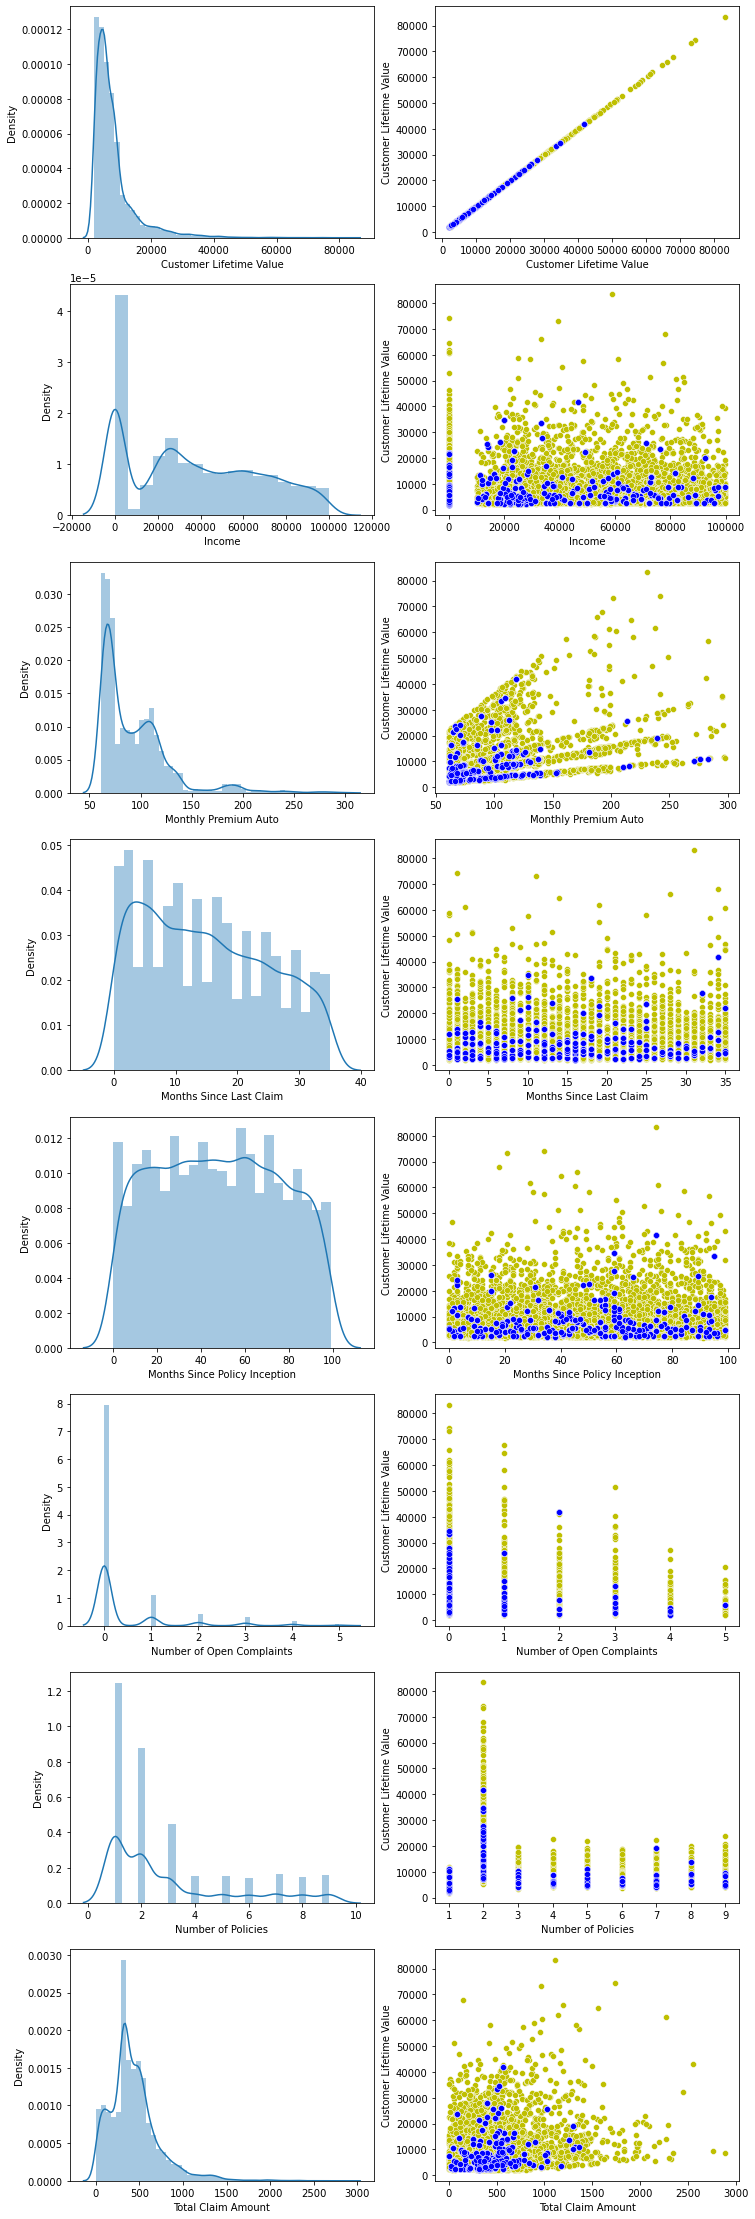

In [7]:
plt.figure(figsize=(12,40))

for i, val in enumerate(numerical_cols):
  plt.subplot(len(numerical_cols), 2, 2*(i+1)-1)  
  sns.distplot(df[val])  
  plt.subplot(len(numerical_cols), 2, 2*(i+1))  
  sns.scatterplot(df[val][df['Response']=='No'],df["Customer Lifetime Value"][df['Response']=='No'],color='y')
  sns.scatterplot(df[val][df['Response']=='Yes'],df["Customer Lifetime Value"][df['Response']=='Yes'],color='b')
  


### TODO: мини вывод по этим графикам

### 2.2.2 Анализ категориальных параметров

В рамках данной работы для всех возможных значений категориалных переменных приведены проценные составляющие признака `Response`.

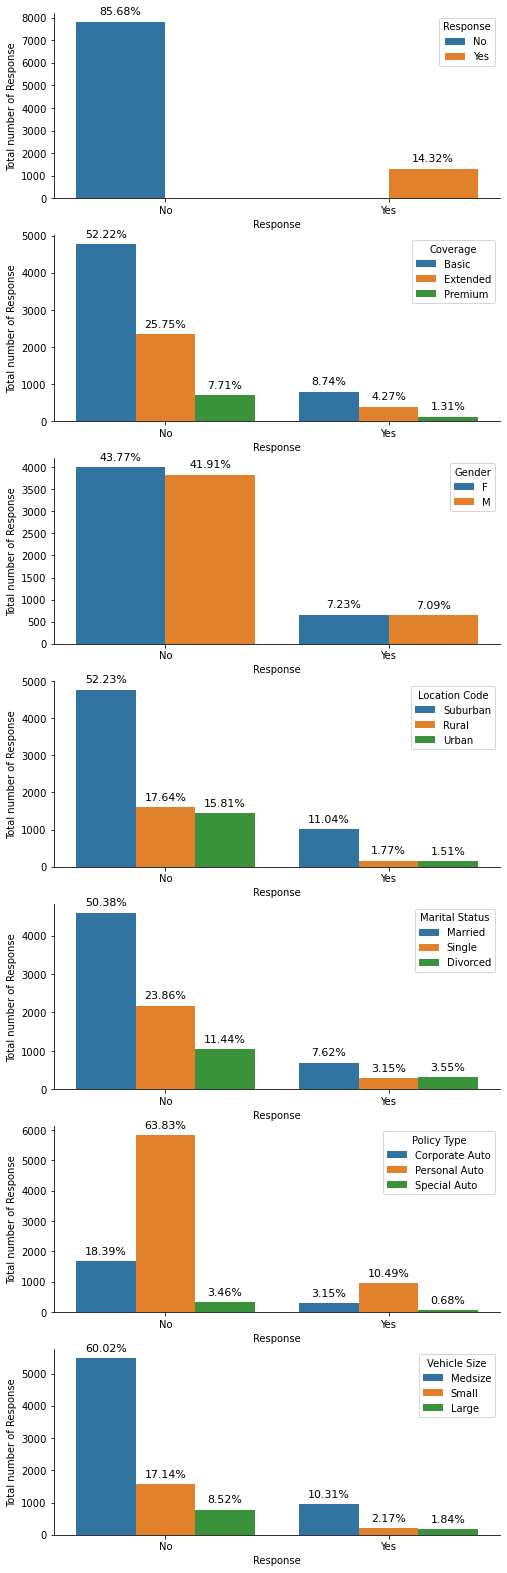

In [8]:
plt.figure(figsize=(2*N_unique,N_unique*7))

for i, val in enumerate(categorical_cols):
  plt.subplot(len(categorical_cols), 1, i+1)
  ax = sns.countplot('Response', hue = val ,data = df)
  plt.ylabel(f'Total number of Response')
  annot_plot(ax, 0.1,1)

### TODO: мини вывод по этим графикам

 - В представленном наборе данных число отказавшихся продлевать контракт 86% сильно больше числа согласившихся продлевать контракт 14%. 

`Отбор параметров для рассмотрения??? `

# 3 Предобработка данных

Хотя цель этого задания - посмотреть на работу алгоритмов, тем не менее пропускать препроцессинг нельзя, так что:
- переведите категориальные переменные в уникальные лейблы при помощи LabelEncoder,
- попробуйте добавить новые переменные и выкинуть лишние 
- наконец, разбейте данные на train-test

## 3.1 Преобразование категориальных переменных


In [9]:
# преобразование с помощью LabelEncoder()
#df['Response'] = df['Response'].apply(lambda X : 0 if X == 'No' else 1)
response_enc = LabelEncoder()
df["Response"] = response_enc.fit_transform(df["Response"])

if "Response" in categorical_cols:
    categorical_cols.remove("Response")

print("Categorical columns are:\n",categorical_cols)

Categorical columns are:
 ['Coverage', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Vehicle Size']


In [10]:
# преобразование данных с помощью функций pandas
def data_preprocessing(data_input, cols_4_drop, cat_cols):    
    data_input = data_input.drop(cols_4_drop, axis=1)
    data_input = pd.get_dummies(data_input, columns=cat_cols, prefix_sep='=')    
    return data_input
    


In [11]:
df = data_preprocessing(df, columns_for_drop, categorical_cols)    

In [12]:
df.head()

,Customer Lifetime Value,Response,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Coverage=Basic,...,Location Code=Urban,Marital Status=Divorced,Marital Status=Married,Marital Status=Single,Policy Type=Corporate Auto,Policy Type=Personal Auto,Policy Type=Special Auto,Vehicle Size=Large,Vehicle Size=Medsize,Vehicle Size=Small
0,2763.519279,0,56274,69,32,5,0,1,384.811147,1,...,0,0,1,0,1,0,0,0,1,0
1,6979.535903,0,0,94,13,42,0,8,1131.464935,0,...,0,0,0,1,0,1,0,0,1,0
2,12887.431650,0,48767,108,18,38,0,2,566.472247,0,...,0,0,1,0,0,1,0,0,1,0
3,7645.861827,0,0,106,18,65,0,7,529.881344,1,...,0,0,1,0,1,0,0,0,1,0
4,2813.692575,0,43836,73,12,44,0,1,138.130879,1,...,0,0,0,1,0,1,0,0,1,0


## 3.2 Нормализация количественных  данных 

In [13]:
# Стандартизация (z-преобразование)  
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [14]:
df.head()

,Customer Lifetime Value,Response,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Coverage=Basic,...,Location Code=Urban,Marital Status=Divorced,Marital Status=Married,Marital Status=Single,Policy Type=Corporate Auto,Policy Type=Personal Auto,Policy Type=Special Auto,Vehicle Size=Large,Vehicle Size=Medsize,Vehicle Size=Small
0,-0.762878,0,0.612827,-0.703925,1.678099,-1.543287,-0.42225,-0.822648,-0.169640,1,...,0,0,1,0,1,0,0,0,1,0
1,-0.149245,0,-1.239617,0.022691,-0.208186,-0.217334,-0.42225,2.106160,2.400737,0,...,0,0,0,1,0,1,0,0,1,0
2,0.710636,0,0.365710,0.429596,0.288205,-0.360680,-0.42225,-0.404247,0.455734,0,...,0,0,1,0,0,1,0,0,1,0
3,-0.052263,0,-1.239617,0.371467,0.288205,0.606907,-0.42225,1.687759,0.329769,1,...,0,0,1,0,1,0,0,0,1,0
4,-0.755575,0,0.203390,-0.587666,-0.307465,-0.145661,-0.42225,-0.822648,-1.018843,1,...,0,0,0,1,0,1,0,0,1,0


## 3.3 Разбиение данных 
В качестве целевого признака выбираем 'Response'. Проведем разбиение данных на

*   train
*   test(validate)


 



In [15]:
# # проверяем, что целевой параметр на входит в признаки
# my_cols = categorical_cols + numerical_cols
# print (my_cols)
# print("Response" in my_cols)
# if "Response" in my_cols:
#     my_cols.remove("Response")


# разделили target и predictors
y = df['Response']
X = df.drop(['Response'], axis=1)


# разиение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

print(X_train.shape)
print(X_test.shape)
print("Categorical columns are:\n",categorical_cols)
print("Numerical columns are:\n",numerical_cols)

# для python интерфейса xgboost
# # для работы с xgboost надо представить данные в формате DMatrix
# dtrain = xgb.DMatrix(X_train, y_train)
# dtest = xgb.DMatrix(X_test, y_test)

(6393, 25)
(2741, 25)
Categorical columns are:
 ['Coverage', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Vehicle Size']
Numerical columns are:
 ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount']


# 4 Методы градиентного бустинга с параметрами по умолчанию

## 4.1 Задание выходного массива для сравнения методов

Определим датафреймы для сравнения результатов

In [16]:
output_cols= ["y_test","gb_predict", "xgb_predict","cgb_predict","lgb_predict"]
#combine pridicts from all methods with default settings 
output_df_def = pd.DataFrame(columns=output_cols)
#combine pridicts from all methods with tuned settings 
output_df_tune = pd.DataFrame(columns=output_cols)
output_df_def[output_cols[0]] = y_test
output_df_tune[output_cols[0]] = y_test
print(output_df_def.head())

      y_test gb_predict xgb_predict cgb_predict lgb_predict
8314       1        NaN         NaN         NaN         NaN
3238       0        NaN         NaN         NaN         NaN
2789       0        NaN         NaN         NaN         NaN
2828       0        NaN         NaN         NaN         NaN
7681       1        NaN         NaN         NaN         NaN


## 4.2 GradientBoosting

In [17]:
# Проведем обучение и предсказание на проведенном нами ранее разбиении см.3.3
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
output_df_def[output_cols[1]] = y_pred
print(output_df_def.head())

      y_test  gb_predict xgb_predict cgb_predict lgb_predict
8314       1           0         NaN         NaN         NaN
3238       0           0         NaN         NaN         NaN
2789       0           0         NaN         NaN         NaN
2828       0           0         NaN         NaN         NaN
7681       1           0         NaN         NaN         NaN


In [18]:
# рассмотрим среднии значения результатов метода при многократной кроссвалидации
model = GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=321) 
n_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
print("for our scores \n \tmean = %0.4f (+/- std = %0.4f)" % (
    np.mean(n_scores),
    np.std(n_scores)
))


for our scores 
 	mean = 0.8889 (+/- std = 0.0126)


## 4.3 XGBoost

In [19]:
# Проведем обучение и предсказание на проведенном нами ранее разбиении см.3.3

#params = {"objective": "binary:logistic", "eval_metric":"logloss"}
#"objective": "reg:logistic" = для определения {0, 1} а не вероятности 
model = XGBClassifier(objective="reg:logistic") #params = {"objective": "reg:logistic"}
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
output_df_def[output_cols[2]] = y_pred
print(output_df_def.head())


      y_test  gb_predict  xgb_predict cgb_predict lgb_predict
8314       1           0            1         NaN         NaN
3238       0           0            0         NaN         NaN
2789       0           0            0         NaN         NaN
2828       0           0            0         NaN         NaN
7681       1           0            1         NaN         NaN


In [20]:
# рассмотрим среднии значения результатов метода при многократной кроссвалидации
model = XGBClassifier(objective="reg:logistic")
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=321) 
n_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
print("for our scores \n \tmean = %0.4f (+/- std = %0.4f)" % (
    np.mean(n_scores),
    np.std(n_scores)
))

for our scores 
 	mean = 0.9989 (+/- std = 0.0045)


## 4.4 CatBoost

In [21]:
# Проведем обучение и предсказание на проведенном нами ранее разбиении см.3.3
model = CatBoostClassifier(eval_metric='AUC',verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
output_df_def[output_cols[3]] = y_pred
print(output_df_def.head())

      y_test  gb_predict  xgb_predict  cgb_predict lgb_predict
8314       1           0            1            1         NaN
3238       0           0            0            0         NaN
2789       0           0            0            0         NaN
2828       0           0            0            0         NaN
7681       1           0            1            1         NaN


In [22]:
# рассмотрим среднии значения результатов метода при многократной кроссвалидации
model = CatBoostClassifier(eval_metric='AUC',verbose=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=321) 
n_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
print("for our scores \n \tmean = %0.4f (+/- std = %0.4f)" % (
    np.mean(n_scores),
    np.std(n_scores)
))

for our scores 
 	mean = 0.9976 (+/- std = 0.0041)


## 4.5 LightGBM

In [23]:
# Проведем обучение и предсказание на проведенном нами ранее разбиении см.3.3
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
output_df_def[output_cols[4]] = y_pred
print(output_df_def.head())

      y_test  gb_predict  xgb_predict  cgb_predict  lgb_predict
8314       1           0            1            1            1
3238       0           0            0            0            0
2789       0           0            0            0            0
2828       0           0            0            0            0
7681       1           0            1            1            1


In [24]:
# рассмотрим среднии значения результатов метода при многократной кроссвалидации
model = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=321) 
n_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
print("for our scores \n \tmean = %0.4f (+/- std = %0.4f)" % (
    np.mean(n_scores),
    np.std(n_scores)
))

for our scores 
 	mean = 0.9981 (+/- std = 0.0036)


## 4.6 Сравнение моделей при запуске "из коробки" (с параметрами по умолчанию) 

В качестве метрики будет использоваться roc_auc

In [25]:
# Как выглядит таблица с предсказаниями разных методов
print(output_df_def.head())
print(output_df_def.tail())

      y_test  gb_predict  xgb_predict  cgb_predict  lgb_predict
8314       1           0            1            1            1
3238       0           0            0            0            0
2789       0           0            0            0            0
2828       0           0            0            0            0
7681       1           0            1            1            1
      y_test  gb_predict  xgb_predict  cgb_predict  lgb_predict
2894       0           0            0            0            0
8341       0           0            0            0            0
2411       0           0            0            0            0
8994       0           0            0            0            0
1245       1           0            1            1            1


In [57]:
# метрика rog_auc при сравнение результатов на единичном обучении 
rog_auc_scores = [roc_auc_score(
                        output_df_def[output_cols[0]],
                        output_df_def[output_cols[i]] 
                        ) for i in range(1,5,1)]

for i, ra_score in enumerate(rog_auc_scores):
    print(f"For {output_cols[i+1]} we have rog_auc_score = {ra_score} ")




For gb_predict we have rog_auc_score = 0.546855425655964 
For xgb_predict we have rog_auc_score = 0.9972316865417377 
For cgb_predict we have rog_auc_score = 0.9465594669926439 
For lgb_predict we have rog_auc_score = 0.9457130967397949 


In [27]:
clf_reports = [classification_report(
                output_df_def[output_cols[0]],
                output_df_def[xgb_method]
                ) for xgb_method in output_cols[1:]]

for i, report in enumerate(clf_reports):    
    print(f"Classification_report for {output_cols[i+1]}:\n", report)

Classification_report for gb_predict:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      2348
           1       0.84      0.10      0.17       393

    accuracy                           0.87      2741
   macro avg       0.86      0.55      0.55      2741
weighted avg       0.86      0.87      0.82      2741

Classification_report for xgb_predict:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      2348
           1       0.97      1.00      0.98       393

    accuracy                           1.00      2741
   macro avg       0.98      1.00      0.99      2741
weighted avg       1.00      1.00      1.00      2741

Classification_report for cgb_predict:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2348
           1       0.98      0.90      0.94       393

    accuracy                           0.98      2741
   macro 

# 5 Настройка гиперпараметров

гиперпараметров моделей на кросс-валидации, можно настраивать только самые основные гиперпараметры - число итераций бустинга, max_features, subsample и т.д.

- Теперь проведите настройку гиперпараметров моделей на кросс-валидации, можно настраивать только самые основные гиперпараметры - число итераций бустинга, max_features, subsample и т.д.
- Снова проверьте качество уже настроенных моделей, кто, в итоге победил?

Настройка параметров отличается для разных реализаций GB. В данном случае будем проводить перебор из множества значений параметров базового алгоритма (определяющих деревья решений). 

Common tree tunable parameters
- **learning rate**: learning rate/eta
- **gamma**: min loss reduction to create new tree split
- **lambda**: L2 reg on leaf weights
- **alpha**: L1 reg on leaf weights
- **max_depth**: max depth per tree
- **subsample**: % samples used per tree
- **colsample_bytree**: % features used per tree

## 5.1 GradientBoosting

In [33]:
# Делаем поиск оптимальных параметров для train см 3.3
# 
gbm_param_grid = {
                'learning_rate': [0.03,0.1],
                "max_depth": [2, 4],
                'n_estimators': [10],
                'subsample': [0.3, 0.95],
                }
gbm = GradientBoostingClassifier()
grid_rocauc = GridSearchCV(estimator=gbm,
                        param_grid=gbm_param_grid,
                        scoring='roc_auc',
                        cv=4,
                        verbose=1)
#print(grid_rocauc.estimator.get_params().keys())
grid_rocauc.fit(X_train, y_train)
print("Best parameters found: ",grid_rocauc.best_params_)
print("Lowest roc_auc found: ", grid_rocauc.best_score_)

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 10, 'subsample': 0.95}
Lowest RMSE found:  0.7689513719981264


In [32]:
# 
best_gbm = GradientBoostingClassifier(**grid_rocauc.best_params_)
best_gbm.fit(X_train,y_train)
y_pred = best_gbm.predict(X_test)
output_df_tune[output_cols[1]] = y_pred
print(output_df_tune.head())

GradientBoostingClassifier(max_depth=4, n_estimators=10, subsample=0.95)
      y_test  gb_predict xgb_predict cgb_predict lgb_predict
8314       1           0         NaN         NaN         NaN
3238       0           0         NaN         NaN         NaN
2789       0           0         NaN         NaN         NaN
2828       0           0         NaN         NaN         NaN
7681       1           0         NaN         NaN         NaN


## 5.2 XGBoost

In [44]:
gbm_param_grid = {                
                'learning_rate': [0.03,0.1],
                "max_depth": [2, 4],
                'n_estimators': [10],
                'subsample': [0.3, 0.95],
                }                
gbm = XGBClassifier(objective="reg:logistic")
grid_rocauc = GridSearchCV(estimator=gbm,
                        param_grid=gbm_param_grid,
                        scoring='roc_auc',
                        cv=4,
                        verbose=0)
grid_rocauc.fit(X, y)
print("Best parameters found: ",grid_rocauc.best_params_)
print("Lowest roc_auc found: ", grid_rocauc.best_score_)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 10, 'subsample': 0.3}
Lowest roc_auc found:  0.7665200410837024


In [45]:
best_gbm = XGBClassifier(objective="reg:logistic",**grid_rocauc.best_params_)
#print(best_gbm)
best_gbm.fit(X_train,y_train)
y_pred = best_gbm.predict(X_test)
output_df_tune[output_cols[2]] = y_pred
print(output_df_tune.head())

      y_test  gb_predict  xgb_predict cgb_predict lgb_predict
8314       1           0            0         NaN         NaN
3238       0           0            0         NaN         NaN
2789       0           0            0         NaN         NaN
2828       0           0            0         NaN         NaN
7681       1           0            0         NaN         NaN


## 5.3 CatBoost

In [55]:
gbm_param_grid = {                
                'learning_rate': [0.03,0.1],
                "max_depth": [2, 4],
                'n_estimators': [10],
                'subsample': [0.3, 0.95],
                }                
gbm = CatBoostClassifier(verbose=0)#objective="reg:logistic")
grid_rocauc = GridSearchCV(estimator=gbm,
                        param_grid=gbm_param_grid,
                        scoring='roc_auc',
                        cv=4,
                        verbose=0)
grid_rocauc.fit(X, y)
print("Best parameters found: ",grid_rocauc.best_params_)
print("Lowest roc_auc found: ", grid_rocauc.best_score_)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 10, 'subsample': 0.95}
Lowest roc_auc found:  0.7019288403202579


In [56]:
best_gbm = CatBoostClassifier(verbose=0,**grid_rocauc.best_params_)
#print(best_gbm)
best_gbm.fit(X_train,y_train)
y_pred = best_gbm.predict(X_test)
output_df_tune[output_cols[3]] = y_pred
print(output_df_tune.head())

      y_test  gb_predict  xgb_predict  cgb_predict  lgb_predict
8314       1           0            0            0            0
3238       0           0            0            0            0
2789       0           0            0            0            0
2828       0           0            0            0            0
7681       1           0            0            0            0


## 5.4 LightGBM

In [52]:
gbm_param_grid = {                
                'learning_rate': [0.03,0.1],
                "max_depth": [2, 4],
                'n_estimators': [10],
                'subsample': [0.3, 0.95],
                }                
gbm = LGBMClassifier()#verbose=0)#objective="reg:logistic")
grid_rocauc = GridSearchCV(estimator=gbm,
                        param_grid=gbm_param_grid,
                        scoring='roc_auc',
                        cv=4,
                        verbose=0)
grid_rocauc.fit(X, y)
print("Best parameters found: ",grid_rocauc.best_params_)
print("Lowest roc_auc found: ", grid_rocauc.best_score_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 10, 'subsample': 0.3}
Lowest roc_auc found:  0.77209474623893


In [54]:
best_gbm = LGBMClassifier(**grid_rocauc.best_params_)
#print(best_gbm)
best_gbm.fit(X_train,y_train)
y_pred = best_gbm.predict(X_test)
output_df_tune[output_cols[4]] = y_pred
print(output_df_tune.head())

      y_test  gb_predict  xgb_predict  cgb_predict  lgb_predict
8314       1           0            0            0            0
3238       0           0            0            0            0
2789       0           0            0            0            0
2828       0           0            0            0            0
7681       1           0            0            0            0


## 5.5 Сравнение моделей (Как сравнивать настроенные моедли?? score_report, а можно еще добавить и как сходится от числа деревьев/итераций???) Есть ли переобучение ???

# Заключение

In [ ]:
- Кроме сравнения качества предсказания, можно сравнивать модели по времени обучения

- Если полнота низкая,
 то есть алгоритм плохо распознает объекты мало представленного класса.
 Если задача заключается в нахождении как раз таких редких объектов, то
 от такого алгоритма мало толку. И надо использовать параметр scale_pos_weight в Xgboost. 